<a href="https://colab.research.google.com/github/seifmaazouz/M.I.A-Training-Repo/blob/task13/M_I_A_TASK_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Setup kaggle connection

In [ ]:
from google.colab import files
uploaded= files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle competitions download -c digit-recognizer

 91% 14.0M/15.3M [00:00<00:00, 66.9MB/s]
100% 15.3M/15.3M [00:00<00:00, 65.6MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip digit-recognizer.zip -d digit-recognizer

Archive:  digit-recognizer.zip
  inflating: digit-recognizer/sample_submission.csv  
  inflating: digit-recognizer/test.csv  
  inflating: digit-recognizer/train.csv  


## Import MNIST Dataset

In [ ]:
data= pd.read_csv('/content/digit-recognizer/train.csv')

In [ ]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = np.array(data)
m, n = data.shape
print("no of examples: ", m)
print("no of features: ", n-1)
np.random.shuffle(data)

no of examples:  42000
no of features:  784


In [ ]:
data_test = data[0:1000].T # transpose so now columns are examples and rows are features
Y_test = data_test[0] # first row is label
X_test = data_test[1:n] # rest of rows are features (pixels)

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]

In [ ]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (784, 41000)
Y_train shape:  (41000,)
X_test shape:  (784, 1000)
Y_test shape:  (1000,)


In [ ]:
Y_train # array of all labels

array([7, 0, 0, ..., 0, 6, 5])

In [ ]:
X_train.shape

(784, 41000)

In [ ]:
# normalize data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Creating NN from scratch

In [ ]:
def init_params():
  # Initialize weights with small random values
  W1 = np.random.randn(10, 784) * 0.01
  b1 = np.zeros((10, 1))  # biases initialized to zero
  W2 = np.random.randn(10, 10) * 0.01
  b2 = np.zeros((10, 1))  # biases initialized to zero
  return W1, b1, W2, b2

In [ ]:
def ReLU(Z):
  return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # subtract max for numerical stability
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
  Z1 = W1.dot(X) + b1[:, :X.shape[1]] # first layer
  A1 = ReLU(Z1) # activation function
  Z2 = W2.dot(A1) + b2[:, :X.shape[1]] # hidden layer
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

In [ ]:
def one_hot(Y):
  one_hot_Y = np.zeros((Y.size, Y.max() + 1))
  one_hot_Y[np.arange(Y.size), Y] = 1
  one_hot_Y = one_hot_Y.T
  return one_hot_Y

def deriv_ReLU(Z):
  return Z > 0

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
  m = Y.size
  one_hot_Y = one_hot(Y)
  dZ2 = A2 - one_hot_Y
  dW2 = 1 / m * dZ2.dot(A1.T)
  db2 = 1 / m * np.sum(dZ2, 0)
  dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
  dW1 = 1 / m * dZ1.dot(X.T)
  db1 = 1 / m * np.sum(dZ1, 0)
  return dW1, db1, dW2, db2

In [ ]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
  W1 = W1 - alpha * dW1
  b1 = b1 - alpha * db1
  W2 = W2 - alpha * dW2
  b2 = b2 - alpha * db2
  return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
  return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
  print(predictions, Y)
  return np.sum(predictions == Y) / Y.size

def cross_entropy_loss(A2, Y):
    m = Y.size  # number of examples
    Y = one_hot(Y)
    return -np.sum(Y * np.log(A2 + 1e-8)) / m  # adding epsilon for stability

def gradient_descent(X, Y, alpha, iterations): # alpha: learning rate
  W1, b1, W2, b2 = init_params()
  for i in range(iterations):
    Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
    if i % 10 == 0:
      predictions = np.argmax(A2, axis=0)
      acc = get_accuracy(predictions, Y)
      loss = cross_entropy_loss(A2, Y)
      print(f"Iteration: {i}, Accuracy: {acc}, Loss: {loss}")
  return W1, b1, W2, b2

# Train NN

In [ ]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 500)

[8 6 4 ... 1 4 8] [7 0 0 ... 0 6 5]
Iteration: 0, Accuracy: 0.08434146341463415, Loss: 2.302333848450672
[8 9 4 ... 1 4 8] [7 0 0 ... 0 6 5]
Iteration: 10, Accuracy: 0.15136585365853658, Loss: 2.301492908173054
[9 9 4 ... 1 4 8] [7 0 0 ... 0 6 5]
Iteration: 20, Accuracy: 0.2549512195121951, Loss: 2.2997622595876246
[9 9 4 ... 3 6 8] [7 0 0 ... 0 6 5]
Iteration: 30, Accuracy: 0.3297560975609756, Loss: 2.2959571658738267
[9 9 8 ... 3 6 8] [7 0 0 ... 0 6 5]
Iteration: 40, Accuracy: 0.36678048780487804, Loss: 2.287512121882419
[9 0 8 ... 3 6 8] [7 0 0 ... 0 6 5]
Iteration: 50, Accuracy: 0.3801219512195122, Loss: 2.2688311695141543
[9 0 8 ... 3 6 8] [7 0 0 ... 0 6 5]
Iteration: 60, Accuracy: 0.4072682926829268, Loss: 2.2286176204051915
[9 0 8 ... 3 6 8] [7 0 0 ... 0 6 5]
Iteration: 70, Accuracy: 0.4509268292682927, Loss: 2.148043293682952
[9 0 0 ... 3 6 8] [7 0 0 ... 0 6 5]
Iteration: 80, Accuracy: 0.5074634146341463, Loss: 2.0068147594048993
[7 0 0 ... 3 6 8] [7 0 0 ... 0 6 5]
Iteration: 9

# Predict Data

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
  _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
  predictions = get_predictions(A2)
  return predictions

def test_prediction(index, W1, b1, W2, b2):
  current_image = X_train[:, index, None]
  prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
  label = Y_train[index]
  print("Prediction: ", prediction[0])
  print("Label: ", label)

  current_image = current_image.reshape((28, 28)) * 255
  plt.gray()
  plt.imshow(current_image, interpolation='nearest')
  plt.show()

Prediction:  0
Label:  0


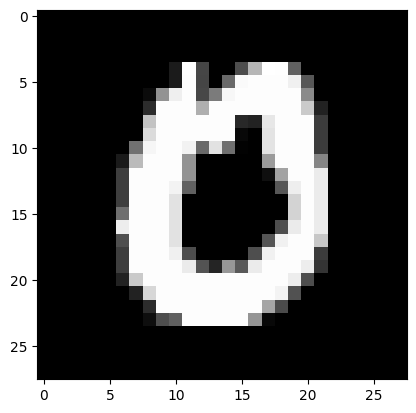

In [ ]:
test_prediction(812, W1, b1, W2, b2) # choose index between 0-4099 (41000 examples)

# Check test data accuracy

In [ ]:
X_test = X_test.reshape((784, X_test.shape[1]))  # Flatten and transpose
test_predictions = make_predictions(X_test, W1, b1, W2, b2)
accuracy = get_accuracy(test_predictions, Y_test)
print("Accuracy: ", accuracy)

[1 0 4 7 4 5 8 4 7 1 0 1 8 6 7 4 1 0 9 9 6 1 5 8 0 4 4 6 3 8 8 4 5 1 5 3 3
 6 0 7 5 1 3 5 4 9 3 7 2 4 2 4 9 6 1 1 0 3 1 5 3 4 2 0 1 2 8 6 6 0 9 1 2 3
 5 0 6 3 6 9 9 0 2 1 9 0 9 3 2 7 6 9 3 4 0 2 1 4 7 7 4 3 6 4 5 7 7 3 1 6 5
 6 7 7 9 5 7 5 7 7 3 3 1 1 0 7 2 2 8 9 1 1 8 7 6 1 0 6 2 7 0 7 0 8 8 0 9 6
 1 2 1 3 5 6 2 8 3 2 0 9 9 5 4 9 6 3 0 8 8 6 1 9 0 0 3 4 9 5 8 8 5 1 1 8 7
 4 6 8 0 8 3 4 2 8 2 9 5 5 8 9 9 3 3 3 6 1 3 0 7 0 9 5 4 9 8 3 5 4 0 2 1 9
 3 9 4 4 5 6 7 8 6 2 5 0 3 9 1 7 1 6 3 5 2 0 0 3 5 4 5 6 8 0 1 3 8 3 2 7 2
 0 7 1 5 2 3 8 9 4 9 9 9 8 5 4 4 4 7 1 7 6 7 9 0 7 1 1 7 5 9 3 9 7 5 6 9 9
 3 6 4 3 2 0 8 6 9 4 4 2 2 3 8 8 3 9 5 7 4 5 4 9 0 6 5 4 3 2 7 0 6 7 0 1 1
 3 8 2 2 3 1 6 3 8 9 0 2 8 4 8 1 0 6 1 7 6 4 4 2 0 2 5 7 1 0 6 7 6 5 5 0 5
 2 7 9 0 7 6 1 9 1 8 0 4 9 4 3 9 7 1 5 5 7 1 6 2 7 8 7 3 5 7 4 9 8 7 1 1 5
 8 2 5 4 1 1 3 7 9 6 4 6 0 8 9 6 6 2 3 5 8 3 1 1 4 1 3 5 7 3 6 5 9 8 2 6 3
 1 1 3 1 3 9 8 3 8 1 6 8 1 2 6 1 6 8 7 6 1 4 9 4 2 0 9 8 5 1 1 8 4 5 7 5 2
 4 1 4 4 6 0 0 0 3 4 7 1 

---

## Build with PyTorch or TensorFlow:

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# import data
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# normalizing
training_images=training_images/255.0
test_images=test_images/255.0

# create cnn model
cnn = models.Sequential([
    layers.Input((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 classes
])

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
cnn.fit(training_images, training_labels, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 118s 31ms/step - accuracy: 0.8983 - loss: 0.3288
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - accuracy: 0.9846 - loss: 0.0488
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.9900 - loss: 0.0315
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - accuracy: 0.9935 - loss: 0.0215
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - accuracy: 0.9942 - loss: 0.0179


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
[1.0314128e-11 8.8633083e-09 8.4665097e-10 1.4275136e-07 3.1069383e-12
 2.1474893e-11 1.3932046e-17 9.9999982e-01 2.6762866e-11 3.0320795e-08]
7


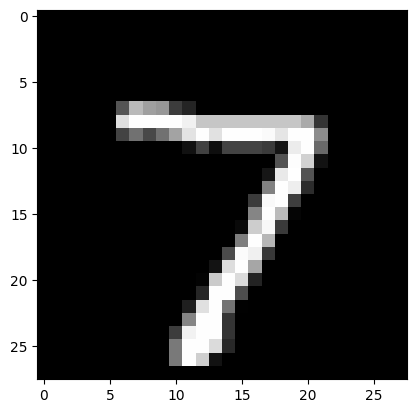

In [ ]:
import matplotlib.pyplot as plt

classifications = cnn.predict(test_images)
print(classifications[0])
print(test_labels[0])

plt.imshow(test_images[0])

In [ ]:
loss, accuracy = cnn.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy:.2f}, Loss: {loss:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9874 - loss: 0.0447
Accuracy: 0.99, Loss: 0.03
